Now let's go on to our modeling step. As a reminder, our plan of action was as follows:

1. Perform EDA on the dataset to extract valuable insight about the process generating the time series **(COMPLETED)**.
2. Build a baseline model (univariable model without exogenous variables) for benchmarking purposes. **(Covered in this notebook)**
3. Build a univariate model with all exogenous variables to check best possible performance. **(Covered in this notebook)**
4. Evaluate the model with exogenous variables and discuss any potential issues. **(Covered in this notebook)**
5. Overcome issues identified above. **(Covered in this notebook)**
6. Make future predictions with the best model.
7. Replicate flow with Automated Time Series Modeling (AutoML)

In [1]:
# Only enable critical logging (Optional)
import os
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

In [2]:
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    !pip install pycaret
    what_is_installed()


System:
    python: 3.10.11 | packaged by Anaconda, Inc. | (main, May 16 2023, 00:55:32) [MSC v.1916 64 bit (AMD64)]
executable: C:\Users\Nikhil\.conda\envs\pycaret_dev_sktime_19p1\python.exe
   machine: Windows-10-10.0.19045-SP0

PyCaret required dependencies:
                 pip: 23.1.2
          setuptools: 67.8.0
             pycaret: 3.0.2
             IPython: 7.34.0
          ipywidgets: 7.7.5
                tqdm: 4.65.0
               numpy: 1.23.0
              pandas: 1.5.3
              jinja2: 3.1.2
               scipy: 1.10.1
              joblib: 1.2.0
             sklearn: 1.2.2
                pyod: 1.0.9
            imblearn: 0.10.1
   category_encoders: 2.6.1
            lightgbm: 3.3.5
               numba: 0.57.0
            requests: 2.31.0
          matplotlib: 3.7.1
          scikitplot: 0.3.7
         yellowbrick: 1.5
              plotly: 5.15.0
    plotly-resampler: Not installed
             kaleido: 0.2.1
           schemdraw: 0.15
         statsmodels: 

In [3]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

In [4]:
# Global Figure Settings for notebook ----
# Depending on whether you are using jupyter notebook, jupyter lab, Google Colab, you may have to set the renderer appropriately
# NOTE: Setting to a static renderer here so that the notebook saved size is reduced.
global_fig_settings = {
    # "renderer": "notebook",
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

In [5]:
data = get_data("airquality")

# Limiting the data for demonstration purposes.
data = data.iloc[-720:]
data["index"] = pd.to_datetime(data["Date"] + " " + data["Time"])
data.drop(columns=["Date", "Time"], inplace=True)
data.replace(-200, np.nan, inplace=True)
target = "CO(GT)"

exclude = ['NMHC(GT)', 'AH']
data.drop(columns=exclude, inplace=True)
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,index
8637,1.5,983.0,5.9,806.0,180.0,820.0,132.0,966.0,615.0,13.5,28.3,2005-03-05 15:00:00
8638,1.8,1018.0,7.3,868.0,255.0,751.0,162.0,1015.0,804.0,13.0,29.7,2005-03-05 16:00:00
8639,2.0,1101.0,8.4,916.0,251.0,721.0,159.0,1125.0,861.0,11.6,38.7,2005-03-05 17:00:00
8640,1.9,1116.0,7.7,888.0,258.0,695.0,156.0,1176.0,980.0,8.6,56.3,2005-03-05 18:00:00
8641,2.5,1161.0,9.1,945.0,344.0,654.0,177.0,1205.0,1077.0,8.5,57.9,2005-03-05 19:00:00


# Step 2: Baseline Model - Univariate forecasting without exogenous variables

In [6]:
data_uni = data.copy()
data_uni.set_index("index", inplace=True)
data_uni = data_uni[target]

exp_uni = TSForecastingExperiment()
exp_uni.setup(
    data=data_uni, fh=48,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=42
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,2.8%
9,Fold Generator,ExpandingWindowSplitter


In [7]:
model = exp_uni.create_model("arima", order=(0,1,0), seasonal_order=(0,1,0,24))

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2005-03-27 14:00,1.5606,1.4904,1.1466,1.6039,0.6598,1.0119,-1.7616
1,2005-03-29 14:00,2.5919,1.9767,1.8655,2.1105,1.4991,0.7419,-2.7317
2,2005-03-31 14:00,1.4605,1.1539,1.0401,1.2124,1.2860,1.2780,-6.2314
Mean,NaT,1.8710,1.5403,1.3507,1.6422,1.1483,1.0106,-3.5749
SD,NaT,0.5114,0.3378,0.3666,0.3676,0.3562,0.2189,1.9197


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

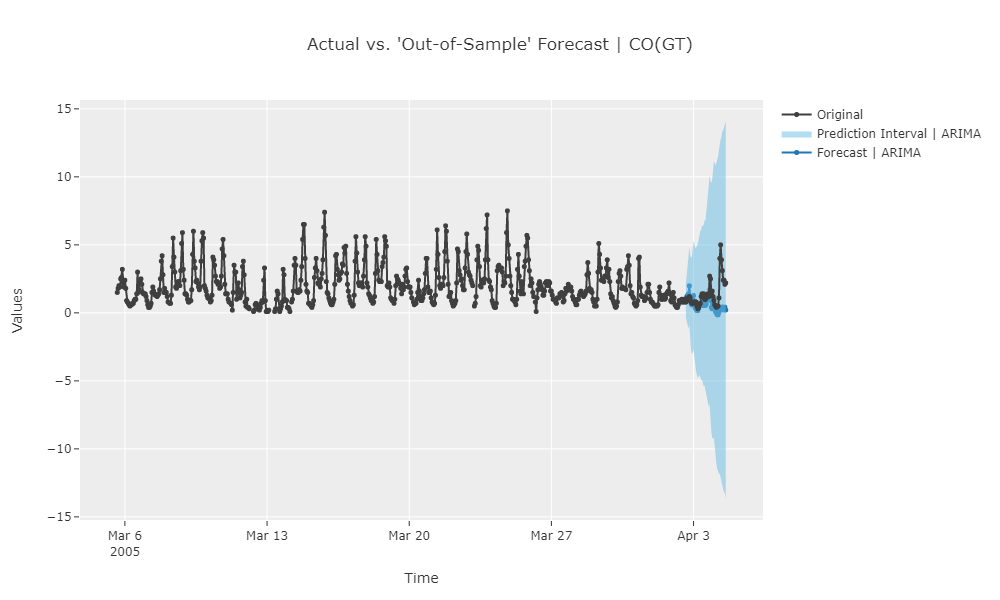

In [8]:
exp_uni.plot_model(model)

On zooming in to the forecasts, we can see that the model is able to capture some of the trends (spikes) in the dataset, but not all. The performance of our baseline model indicates that mean MASE across the CV folds is 1.52 which is not that great. Any value > 1 indicates that the model is performing worse than even a naive model with one step ahead forecasts. This model needs more improvement. Let's see if adding exogenous variables can help improve the model performance.

# Step 3: Improved Model - Univariate forecasting with exogenous variables

In [9]:
exp_exo = TSForecastingExperiment()
exp_exo.setup(
    data=data, target=target, index="index", fh=48,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=42
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(720, 11)"
5,Transformed data shape,"(720, 11)"
6,Transformed train set shape,"(672, 11)"
7,Transformed test set shape,"(48, 11)"
8,Rows with missing values,3.8%
9,Fold Generator,ExpandingWindowSplitter


In [10]:
model_exo = exp_exo.create_model("arima", order=(0,1,0), seasonal_order=(0,1,0,24))

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2005-03-27 14:00,0.2512,0.2282,0.1846,0.2455,0.1089,0.1192,0.9353
1,2005-03-29 14:00,0.2321,0.2227,0.1670,0.2378,0.1100,0.1219,0.9526
2,2005-03-31 14:00,0.2525,0.2733,0.1798,0.2872,0.1723,0.1572,0.5943
Mean,NaT,0.2453,0.2414,0.1771,0.2568,0.1304,0.1328,0.8274
SD,NaT,0.0093,0.0227,0.0074,0.0217,0.0296,0.0173,0.1650


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

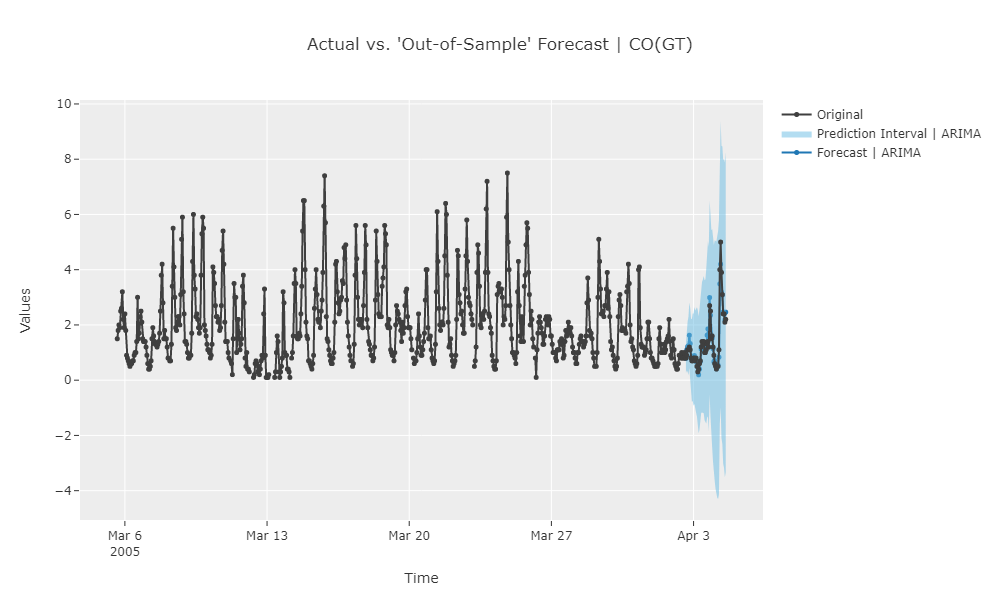

In [11]:
exp_exo.plot_model(model_exo)

# Step 4: Evaluate Model

Not bad, We have managed to improve MASE significantly which is much better than the univariate model and also a large improvement over a naive model. We should be happy with this improvement. Let's finalize the model by training it on the entire dataset so we can make true future forecasts.

In [12]:
final_model_exo = exp_exo.finalize_model(model_exo)

In [13]:
def safe_predict(exp, model):
    """Prediction wrapper for demo purposes."""
    try: 
        exp.predict_model(model)
    except ValueError as exception:
        print(exception)
        exo_vars = exp.exogenous_variables
        print(f"{len(exo_vars)} exogenous variables (X) needed in order to make future predictions:\n{exo_vars}")

safe_predict(exp_exo, final_model_exo)

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
10 exogenous variables (X) needed in order to make future predictions:
['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH']


As we can see, this approach does not come without side effects. The problem is that we have 10 exogenous variables. Hence in order to get any unknown future values for CO concentration, we will need the future values for all these exogenous variables. This is generally obtained through some forecasting process itself. But each forecast will have errors and these errors can be compounded when there are a lot of exogenous variables. 

**Let's see if we can trim down these exogenous variables to a handful of useful variables without compromising on forecasting performance.**

# Step 5: Parsimonious Model - Univariate forecasting with limited exogenous variables

From the CCF Analysis, we found that many of the exogenous variables show a very similar correlation structure to the CO concentration. E.g. `PT08.S1(CO)`, `NOx(GT)`, `C6H6(GT)`, `PT08.S2(NMHC)` values from 24 hours before (lag = 24) show a high positive correlation to CO concentration. Instead of keeping all of them, lets pick the one with the highest positive correlation at lag 24 which is `NOx(GT)`.

Similarly, `PT08.S3(NOx)` values from 24 hours ago shows the highest negative correlation to CO concentration. Let's keep this variable as well.

Finally, in daily cycles, what happens 12 hours back can also impact the current value (e.g. values last night can impact the next day and vice versa). The variable with the highest correlation to CO concentration at lag = 12 is `RH`. We will keep this as well.

In [14]:
exp_slim = TSForecastingExperiment()
keep = [target, "index", 'NOx(GT)', "PT08.S3(NOx)", "RH"]
data_slim = data[keep]
exp_slim.setup(
    data=data_slim, target=target, index="index", fh=48,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=42 
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(720, 4)"
5,Transformed data shape,"(720, 4)"
6,Transformed train set shape,"(672, 4)"
7,Transformed test set shape,"(48, 4)"
8,Rows with missing values,3.8%
9,Fold Generator,ExpandingWindowSplitter


In [15]:
model_slim = exp_slim.create_model("arima", order=(0,1,0), seasonal_order=(0,1,0,24))

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2005-03-27 14:00,0.5014,0.4028,0.3684,0.4334,0.2663,0.2255,0.7983
1,2005-03-29 14:00,0.2657,0.2369,0.1912,0.2529,0.1004,0.0993,0.9464
2,2005-03-31 14:00,0.3023,0.2847,0.2153,0.2992,0.2132,0.1967,0.5596
Mean,NaT,0.3565,0.3081,0.2583,0.3285,0.1933,0.1738,0.7681
SD,NaT,0.1035,0.0697,0.0784,0.0766,0.0692,0.0540,0.1593


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

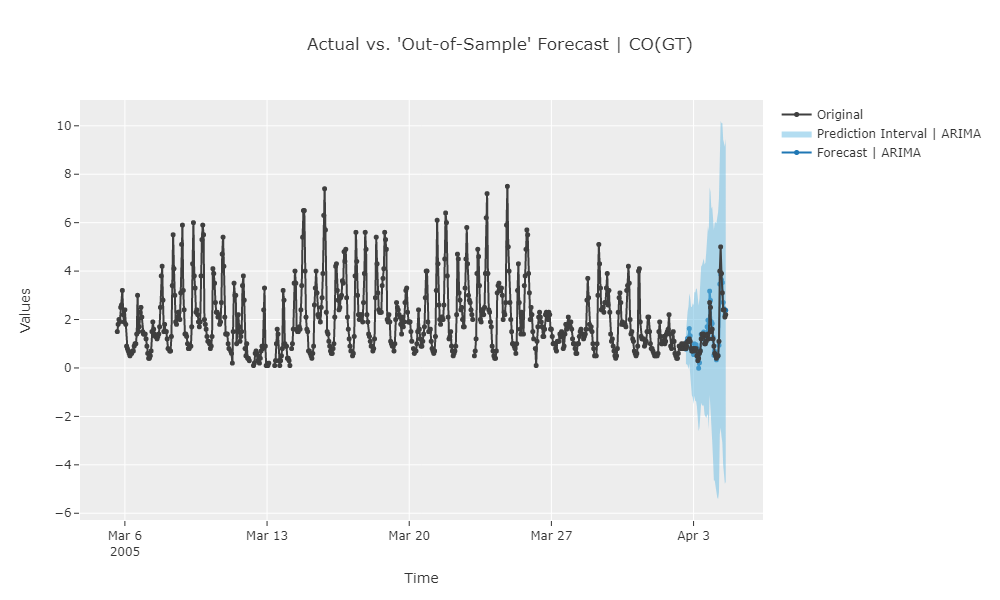

In [16]:
exp_slim.plot_model(model_slim)

Not bad. MASE has only increased slightly, but we have managed to cut our exogenous variables significantly. This will help us when we make "true" unknown future predictions since we will need the "unknown" future values of these exogenous variables to make the forecast for the CO concentration.

# Finalize the model

- Train the slim model on the entire dataset so we can make true future forecasts
- Save the model as a pickle file for deployment 

In [17]:
final_slim_model = exp_slim.finalize_model(model_slim)

In [18]:
_ = exp_slim.save_model(final_slim_model, "final_slim_model")

Transformation Pipeline and Model Successfully Saved


In [19]:
safe_predict(exp_slim, final_slim_model)

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
3 exogenous variables (X) needed in order to make future predictions:
['NOx(GT)', 'PT08.S3(NOx)', 'RH']


**So we still need future values for 3 exogenous variables. We will get this in the next part using forecasting techniques.**

### The next steps would typically be done in a new session/notebook

Now that we have build our model, let's make future predictions. As a reminder, our plan of action was as follows:

1. Perform EDA on the dataset to extract valuable insight about the process generating the time series **(COMPLETED)**.
2. Build a baseline model (univariable model without exogenous variables) for benchmarking purposes **(COMPLETED)**.
3. Build a univariate model with all exogenous variables to check best possible performance **(COMPLETED)**.
4. Evaluate the model with exogenous variables and discuss any potential issues **(COMPLETED)**.
5. Overcome issues identified above **(COMPLETED)**.
6. Make future predictions with the best model. **(Covered in this notebook)**
7. Replicate flow with Automated Time Series Modeling (AutoML)

In [20]:
exog_vars = ['NOx(GT)', 'PT08.S3(NOx)', 'RH']
data = data[["index"] + exog_vars]
data.head()

,index,NOx(GT),PT08.S3(NOx),RH
8637,2005-03-05 15:00:00,180.0,820.0,28.3
8638,2005-03-05 16:00:00,255.0,751.0,29.7
8639,2005-03-05 17:00:00,251.0,721.0,38.7
8640,2005-03-05 18:00:00,258.0,695.0,56.3
8641,2005-03-05 19:00:00,344.0,654.0,57.9


# Step 6: Making Future Predictions

# Step 6A: Get future exogenous variable values using forecasting

In [21]:
exog_exps = []
exog_models = []
for exog_var in exog_vars:
    exog_exp = TSForecastingExperiment()
    exog_exp.setup(
        data=data[["index", exog_var]], target=exog_var, index="index", fh=48,
        numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
        fig_kwargs=global_fig_settings, session_id=42
    )

    # Users can customize how to model future exogenous variables i.e. add
    # more steps and models to potentially get better models at the expense
    # of higher modeling time.
    best = exog_exp.compare_models(
        sort="mase", include=["arima", "ets", "exp_smooth", "theta", "lightgbm_cds_dt",]        
    )
    final_exog_model = exog_exp.finalize_model(best)

    exog_exps.append(exog_exp)
    exog_models.append(final_exog_model)

# Step 2: Get future predictions for exog variables ----
future_exog = [
    exog_exp.predict_model(exog_model)
    for exog_exp, exog_model in zip(exog_exps, exog_models)
]
future_exog = pd.concat(future_exog, axis=1)
future_exog.columns = exog_vars

,Description,Value
0,session_id,42
1,Target,NOx(GT)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.8%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
arima,ARIMA,0.8406,0.9158,87.3689,133.0642,0.4273,0.3443,-1.3072,0.3200
exp_smooth,Exponential Smoothing,0.8954,0.8400,93.0132,121.9760,0.4828,0.5917,-0.9311,0.1667
theta,Theta Forecaster,1.0279,0.9437,107.4620,137.6886,0.5192,0.4990,-0.4072,0.0533
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.2021,1.1033,124.6215,160.1069,0.6995,0.5078,-2.5717,1.5100
ets,ETS,1.6466,1.5514,171.0757,225.4193,0.9284,0.5548,-4.3206,1.5600


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,PT08.S3(NOx)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.1%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
exp_smooth,Exponential Smoothing,1.2435,1.2056,126.5383,158.9241,0.1738,0.1695,-0.0211,0.1533
ets,ETS,1.3630,1.3140,138.7259,173.2545,0.1906,0.1879,-0.2091,0.7067
theta,Theta Forecaster,1.3716,1.3079,139.5929,172.4272,0.1909,0.1878,-0.1963,0.0533
arima,ARIMA,1.3929,1.3245,141.6775,174.6211,0.1792,0.1953,-0.3985,0.4133
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.6778,1.5491,170.7442,204.2588,0.2197,0.2541,-0.7666,1.4900


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,RH
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.1%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
theta,Theta Forecaster,1.6218,1.4765,11.3749,13.1578,0.2481,0.2286,-0.0585,0.0533
arima,ARIMA,1.8001,1.6165,12.6310,14.4108,0.2548,0.2523,-0.2695,0.0867
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,2.7797,2.6115,19.4667,23.2519,0.5241,0.3609,-4.8711,0.8100
exp_smooth,Exponential Smoothing,5.2972,4.7592,37.2423,42.4918,0.7188,0.9298,-10.5261,0.1400
ets,ETS,5.3235,4.7812,37.4259,42.6872,0.7228,0.9349,-10.5911,0.1233


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

In [22]:
future_exog

,NOx(GT),PT08.S3(NOx),RH
2005-04-04 15:00,247.2036,651.1830,13.0838
2005-04-04 16:00,274.0699,644.2770,13.1056
2005-04-04 17:00,298.6685,613.3309,13.0876
2005-04-04 18:00,231.8742,558.1970,13.1094
2005-04-04 19:00,398.1459,499.6994,13.0913
2005-04-04 20:00,378.3662,524.6385,13.1131
2005-04-04 21:00,252.7246,596.2236,13.0950
2005-04-04 22:00,246.6336,684.6523,13.1169
2005-04-04 23:00,180.6670,721.4174,13.0988
2005-04-05 00:00,125.5157,756.1241,13.1206


# Step 6B: Load Model and make future predcitons for the target variable

In [23]:
exp_future = TSForecastingExperiment()

In [24]:
final_slim_model = exp_future.load_model("final_slim_model")

Transformation Pipeline and Model Successfully Loaded


<Axes: >

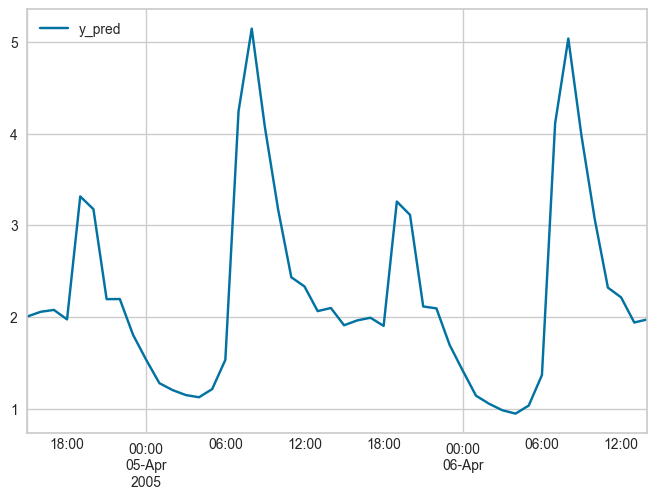

In [25]:
future_preds = exp_future.predict_model(final_slim_model, X=future_exog)
future_preds.plot()